Using https://www.kaggle.com/cyannani123/keras-cellular-image-classification as test example

In [1]:
import os

In [2]:
import sys

In [3]:
import numpy as np
import pandas as pd

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
tf.__version__

'2.3.0'

In [8]:
from tensorflow.python.client import device_lib

In [9]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17688174442802433486
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12414360420467422329
physical_device_desc: "device: XLA_CPU device"
]


In [10]:
import tensorflow.keras as keras

In [11]:
from sklearn.preprocessing import LabelEncoder

ModuleNotFoundError: No module named 'sklearn'

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.utils import Sequence

In [14]:
import os, sys, random,copy
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter
from sklearn.model_selection import train_test_split

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

Loading test and train data.

Will load directly from zip for now.

In [16]:
import zipfile

In [17]:
from io import StringIO, BytesIO

In [17]:
archive = zipfile.ZipFile('./input/recursion-cellular-image-classification.zip','r')

In [18]:
test_data = pd.read_csv(BytesIO(archive.read('test.csv')))
print("Shape of test_data:", test_data.shape)
test_data.head()

Shape of test_data: (19899, 4)


,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07


In [19]:
train_data = pd.read_csv("../input/train.csv")
print("Shape of test_data:", train_data.shape)
train_data.head()

Shape of test_data: (36517, 5)


,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,sirna_250
1,HEPG2-01_1_B04,HEPG2-01,1,B04,sirna_62
2,HEPG2-01_1_B05,HEPG2-01,1,B05,sirna_1115
3,HEPG2-01_1_B06,HEPG2-01,1,B06,sirna_602
4,HEPG2-01_1_B07,HEPG2-01,1,B07,sirna_529


In [20]:
sirna_label_encoder = LabelEncoder().fit(train_data.sirna)

Proovime kirjutada dataset-i faili.from azureml.core import Workspace, Dataset


In [21]:
from azureml.core import Workspace, Dataset


Laeme training data kõik mällu

In [22]:
from retry import retry

In [23]:
@retry(tries=3)
def get_input(experiment, plate, well, site, channel, train=True):
    
    if train==True:
        base_path = 'train'
    else:
        base_path = 'test'
    
    try:
        path = f"{base_path}/{experiment}/Plate{plate}/{well}_s{str(site)}_w{str(channel)}.png"
        img = Image.open(BytesIO(archive.read(path)))
    except KeyError as err:
        print(f"Error loading input - {err}")
        print("Will default to other site")
        
        # hack mis aitab kahe puuduva pildi puhul
        # pm kui puudub pilt siis proovib lihtsalt teist saiti võtta
        if site==2:
            path = f"{base_path}/{experiment}/Plate{plate}/{well}_s1_w{str(channel)}.png"
            img = Image.open(BytesIO(archive.read(path)))
        else:
            path = f"{base_path}/{experiment}/Plate{plate}/{well}_s2_w{str(channel)}.png"
            img = Image.open(BytesIO(archive.read(path)))
            
    imgr = img.resize( (224,224) )
    
    return imgr

In [24]:
arg_namelist = archive.namelist()

In [25]:
def check_input(experiment, plate, well, site, channel, train=True):
    if train==True:
        base_path = 'train'
    else:
        base_path = 'test'
        
    path = f"{base_path}/{experiment}/Plate{plate}/{well}_s{str(site)}_w{str(channel)}.png"
        
    if path in arg_namelist:
        return True
    else:
        print(f"{path} does not exist")
        return False
    
    

Saidid on samast wellist tehtud eri pildid. Pm võib võtta ainult ühe saidi sisse.
Channelid on eri kanalitega tehtud pildid. Neid on kokku 6.

Kirjutan piltide laadimise klassi notebooki näitel

In [26]:
class ImgGen(Sequence):
    def __init__(self, label_data, batch_size = 32, preprocess=(lambda x: x), shuffle=False):
    
        if shuffle:
            self.label_data=label_data.sample(frac=1).reset_index(drop=True)
        else:
            self.label_data=label_data
        
        self.batch_size=batch_size
        self.preprocess=preprocess
        
    def __len__(self):
        return int(np.ceil(len(self.label_data))/float(self.batch_size))

    def __getitem__(self, i):
        
        batch_x = self.label_data.loc[i*self.batch_size:(i+1)*self.batch_size,("experiment","plate","well")]
        batch_y = self.label_data.loc[i*self.batch_size:(i+1)*self.batch_size,("sirna")]
        
        x_s1_c1 = [np.array(get_input(e, p, w, site=1, channel=1))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c2 = [np.array(get_input(e, p, w, site=1, channel=2))/255 for e, p, w in batch_x.values.tolist()]
        x_s1_c3 = [np.array(get_input(e, p, w, site=1, channel=3))/255 for e, p, w in batch_x.values.tolist()]
        
        x_s2_c1 = [np.array(get_input(e, p, w, site=2, channel=1))/255 for e, p, w in batch_x.values.tolist()]
        x_s2_c2 = [np.array(get_input(e, p, w, site=2, channel=2))/255 for e, p, w in batch_x.values.tolist()]
        x_s2_c3 = [np.array(get_input(e, p, w, site=2, channel=3))/255 for e, p, w in batch_x.values.tolist()]

        x1 = np.array([x_s1_c1,x_s1_c2,x_s1_c3]).transpose((1,2,3,0))
        x2 = np.array([x_s2_c1,x_s2_c2,x_s2_c3]).transpose((1,2,3,0))
        
        y = sirna_label_encoder.transform(batch_y)
        
        return [np.array(x1), np.array(x2)], y
        
        
       

In [27]:
train = ImgGen(train_data)

In [28]:
len(train)

1141

In [ ]:
%timeit first_batch=train[0]

In [31]:
first_batch=train[0]

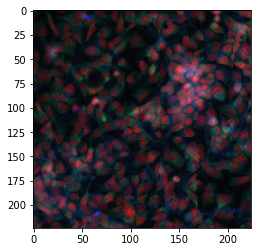

In [32]:
first_image_site1 = first_batch[0][0][0]
plt.imshow(first_image_site1, interpolation='nearest')

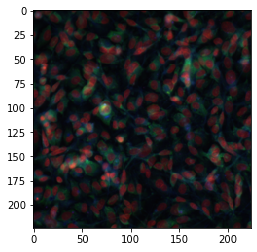

In [33]:
first_image_site2 = first_batch[0][1][0]
plt.imshow(first_image_site2, interpolation='nearest')

In [34]:
first_image_site2.shape

(224, 224, 3)

Image augmentation code

In [35]:
def augment(image):
    random_transform = random.randint(-1,4)
    if random_transform==0:
        image = image.rotate(random.randint(-5,5))
    if random_transform==1:
        image = image.filter(ImageFilter.GaussianBlur(radius=1))
    if random_transform==2:
        image = image.filter(ImageFilter.RankFilter(size=3, rank=1))
    if random_transform==3:
        image = image.filter(ImageFilter.MedianFilter(size=3))
    if random_transform==4:
        image = image.filter(ImageFilter.MaxFilter(size=3))
    return image


In [36]:
def create_model():
    effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
    site1 = Input(shape=(224,224,3))
    site2 = Input(shape=(224,224,3))
    x = effnet(site1)
    x = GlobalAveragePooling2D()(x)
    x = Model(inputs=site1, outputs=x)
    y = effnet(site2)
    y = GlobalAveragePooling2D()(y)
    y = Model(inputs=site2, outputs=y)
    combined = concatenate([x.output, y.output])
    z = Dropout(0.5)(combined)
    z = Dense(1108, activation='softmax')(z)
    model = Model(inputs=[x.input, y.input], outputs=z)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    model.summary()
    
    return model

model = create_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 7, 7, 1280)   4049571     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnetb0[0][0]       

Training model

In [37]:
test_size = 0.025
batch_size = 32

In [38]:
train, val = train_test_split(train_data, test_size=test_size)

In [39]:
print(f"Training set size {len(train)}")
print(f"Validation set size {len(val)}")

Training set size 35604
Validation set size 913


In [40]:
train_gen = ImgGen(train,batch_size=batch_size,preprocess=augment,shuffle=True)
val_gen = ImgGen(val,batch_size=batch_size,preprocess=augment,shuffle=True)

In [41]:
print(f"Training set batched size {len(train_gen)}")
print(f"Validation set batched size {len(val_gen)}")

Training set batched size 1112
Validation set batched size 28


In [42]:
filepath = 'ModelCheckpoint_all.h5'

In [43]:
callback = [
        ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        ]

In [44]:
history = model.fit(train_gen, 
                              steps_per_epoch=len(train)//batch_size, 
                              epochs=1, 
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=len(val)//batch_size,
                              callbacks=callback
                             )

  87/1112 [=>............................] - ETA: 1:10:16 - loss: 7.1353 - accuracy: 0.0000e+00

KeyboardInterrupt: 